In [26]:
import cv2
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
from skimage import draw
from scipy import ndimage

In [27]:
# approximation
UPPER_BOUNDS_CAM1 = [[110,150], [95,175],
                     [90,200], [85,225], [82,250], [80,275], 
                     [78,300], [75,325], [73,350], [73,375],
                     [72,400], [71,425], [71,450], [71,475],
                     [70,500], [70,525], [70,550], [70,575],
                     [70,600], [70,625], [70,650], [70,675],
                     [70,700], [70,725], [70,750], [70,775],
                     [75,800], [73,825], [75,850], [76,875],
                     [77,900], [78,925], [78,950], [81,975],
                     [82,1000], [88,1025], [94,1050], 
                     [100,1075], [100,1100], [120,1125]]

UPPER_BOUNDS_CAM3 = [[845,150], [845,175],
                     [840,200], [835,225], [827,250], [819,275], 
                     [805,300], [790,325], [775,350], [750,375],
                     [730,400], [710,425], [690,450], [665,475],
                     [630,500], [600,525], [560,550], [550,575],
                     [505,600], [400,625], [380,650], [380,675],
                     [380,700], [380,725], [380,750], [380,775],
                     [380,800], [380,825], [380,850], [380,875],
                     [380,900], [380,925], [380,950], [380,975],
                     [380,1000], [380,1025], [380,1050], [380,1075], 
                     [380,1100]]

UPPER_BOUNDS_CAM3B = [[800,600], [800,625], [800,650], [800,675],
                     [800,700], [800,725], [800,750], [800,775],
                     [800,800], [800,825], [800,850], [800,875],
                     [800,900], [800,925], [800,950], [800,975],
                     [800,1000]]

LOWER_BOUNDS_CAM3C = [[700,900], [715,925], [725,950], [730,975],
                     [740,1000], [750,1025], [760,1050], [765,1075], 
                     [765,1100]]

UPPER_BOUNDS_CAM1 = np.array(UPPER_BOUNDS_CAM1)
UPPER_BOUNDS_CAM3 = np.array(UPPER_BOUNDS_CAM3)
UPPER_BOUNDS_CAM3B = np.array(UPPER_BOUNDS_CAM3B)
LOWER_BOUNDS_CAM3C = np.array(LOWER_BOUNDS_CAM3C)

In [28]:
# filename is an image file
def preprocess_image(filename):
    bgr_image       = cv2.imread(filename)
    bgr_image       = increase_brightness(bgr_image, value=40)
    rgb_image       = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image45     = ndimage.rotate(rgb_image, -45)
    
    gray_image      = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    gray_image45    = ndimage.rotate(gray_image, -45)
    
    _, binary_image = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY)
    binary_image    = binary_image/255
    
    _, binary_image45 = cv2.threshold(gray_image45, 220, 255, cv2.THRESH_BINARY)
    binary_image45    = binary_image45/255
    
    return binary_image, rgb_image, binary_image45, rgb_image45

In [29]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [30]:
# points is a starting coordinate --> [y,x]
# this function is used in inversed_hieghts() function
def count_pixel(binary_image, points, topdown=True):
    y = points[0]
    x = points[1]
    no_of_pixels = 0
    
    while binary_image[y,x] == 1:
        if topdown == True:
            y += 1
        else:
            y -= 1
        no_of_pixels += 1
    
    return no_of_pixels

In [31]:
# calculate_heights was previously inversed_heights()
def calculate_heights(binary_image, starting_points, topdown=True):
    heights = []
    for points in starting_points:
        height = count_pixel(binary_image, points, topdown)
        heights.append(height)
    
    return np.array(heights)

In [32]:
# calculates the actual water height
# (container_height - inversed_height)
def actual_height(inversed_height):
    return 320-inversed_height

In [33]:
def pixel_to_mm(value):
    return value*0.828

In [34]:
# determine the actual boundary location
def find_boundary_coords(inversed_height_points, upper_bounds):
    y_locs = upper_bounds[:,0] + inversed_height_points
    x_locs = upper_bounds[:,1]
    
    y_locs = y_locs[:,np.newaxis]
    x_locs = x_locs[:,np.newaxis]
    
    coords = np.hstack((y_locs, x_locs))
    
    return coords

In [35]:
def line_indices(boundary_coords):
    rrs = []
    ccs = []
    for i in range(len(boundary_coords)-1):
        y0 = boundary_coords[i][0]
        x0 = boundary_coords[i][1]
        y1 = boundary_coords[i+1][0]
        x1 = boundary_coords[i+1][1]
        
        rr, cc, _ = draw.line_aa(y0, x0, y1, x1)
        rrs.append(rr)
        ccs.append(cc)
    
    return rrs, ccs

In [36]:
def draw_lines(rgb_image, rrs, ccs):
    for rr, cc in zip(rrs, ccs):
        rgb_image[rr,cc,0] = 0
        rgb_image[rr,cc,1] = 0
        rgb_image[rr,cc,2] = 255
        
        rgb_image[rr+1,cc+1,0] = 0
        rgb_image[rr+1,cc+1,1] = 0
        rgb_image[rr+1,cc+1,2] = 255
    
    return rgb_image

# Main code goes below (this is file #12)

In [37]:
binary_image, rgb_image, binary_image45, rgb_image45 = preprocess_image('cam3_images/CCFL040_10_2000_335_up_a_0003.bmp')

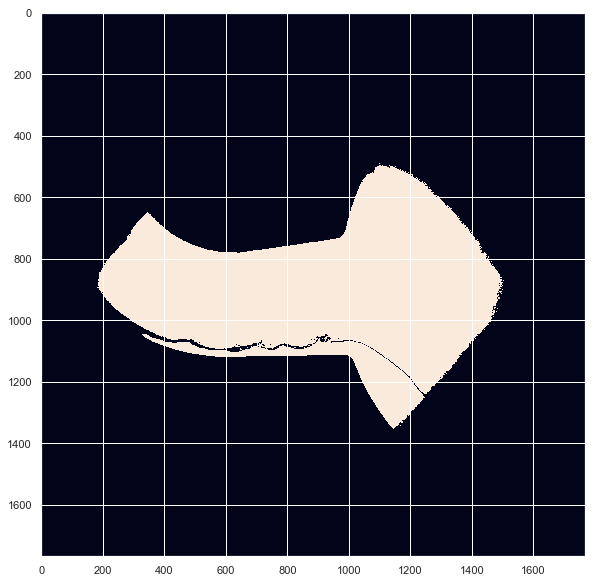

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(binary_image45)

In [39]:
heights = calculate_heights(binary_image45, UPPER_BOUNDS_CAM3B, topdown=True)
boundary_coords = find_boundary_coords(heights, UPPER_BOUNDS_CAM3B)
rrs, ccs = line_indices(boundary_coords)
rgb_image_with_line = draw_lines(rgb_image45, rrs, ccs)

In [40]:
actual_height(heights)

array([26, 31, 36, 37, 43, 40, 29, 39, 39, 33, 32, 41, 70, 72, 50, 56, 54])

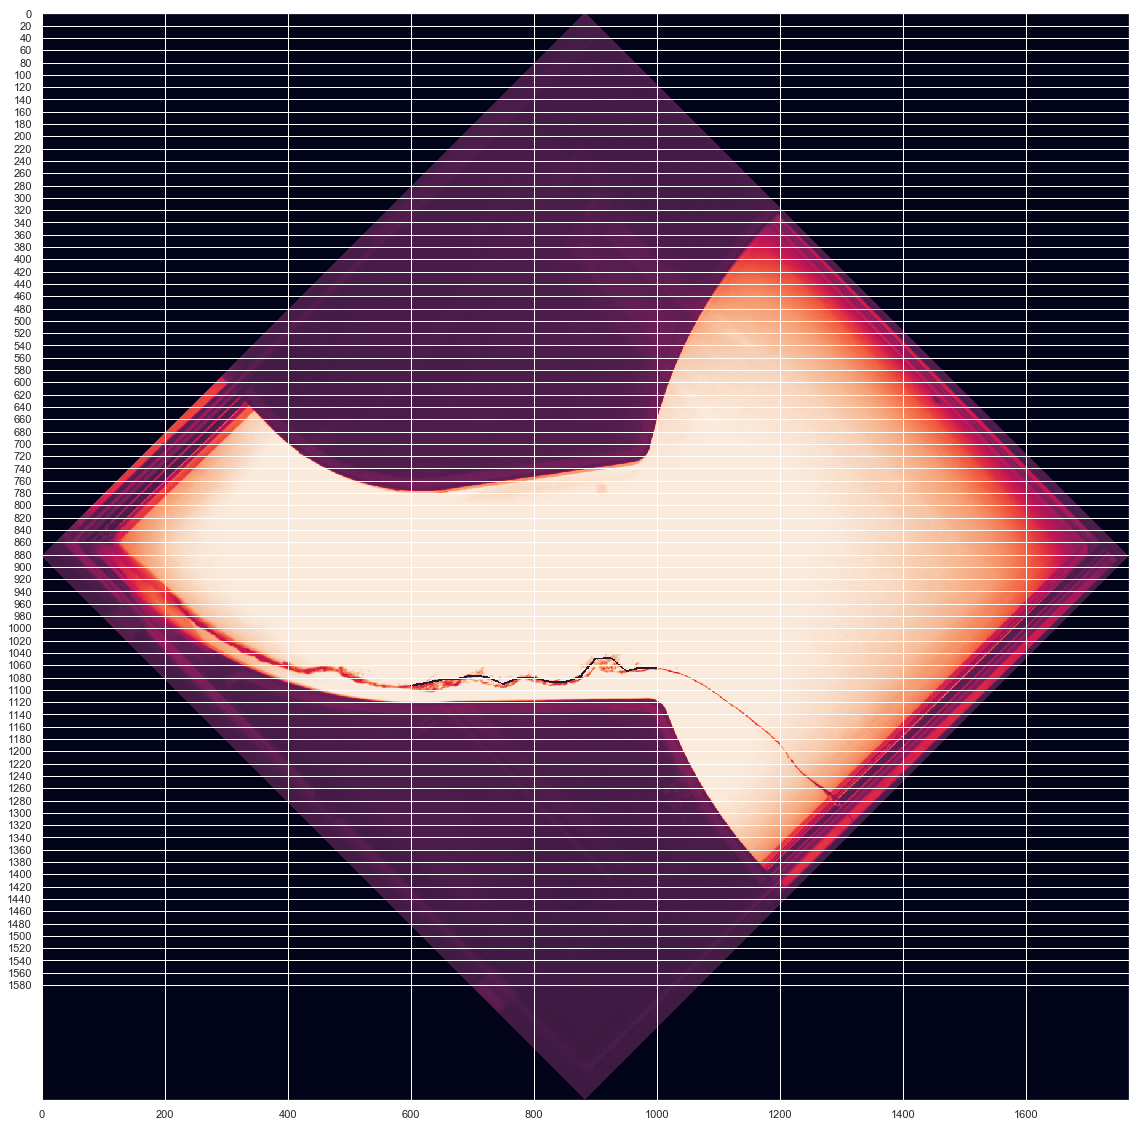

In [41]:
plt.figure(figsize=(20,20))
plt.yticks(np.arange(0, 1600, 20))
plt.imshow(cv2.cvtColor(rgb_image_with_line, cv2.COLOR_RGB2GRAY))

In [42]:
heights = calculate_heights(binary_image, LOWER_BOUNDS_CAM3C, topdown=False)
heights = pixel_to_mm(heights)

In [43]:
heights

array([ 49.68 ,  67.068,  78.66 ,  86.112,  97.704, 108.468, 117.576,
       120.888, 117.576])

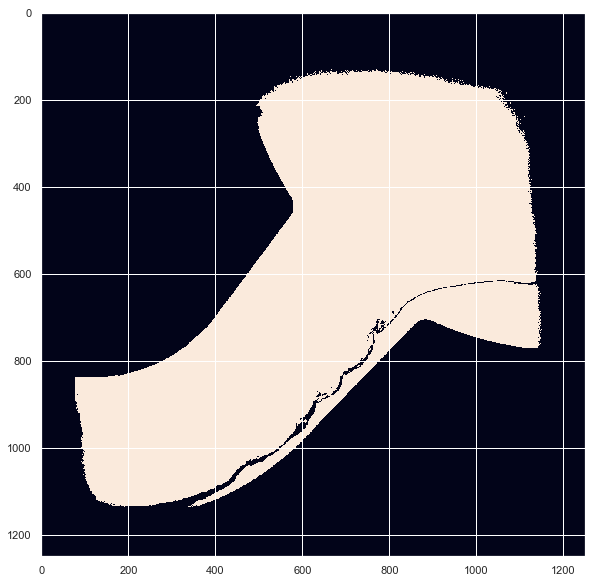

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(binary_image)